# Question 1 - RNNs

In this section, you will implement a simple Recurrent Neural Network (RNN) from scratch to perform sequence prediction using the IMDb movie reviews dataset.

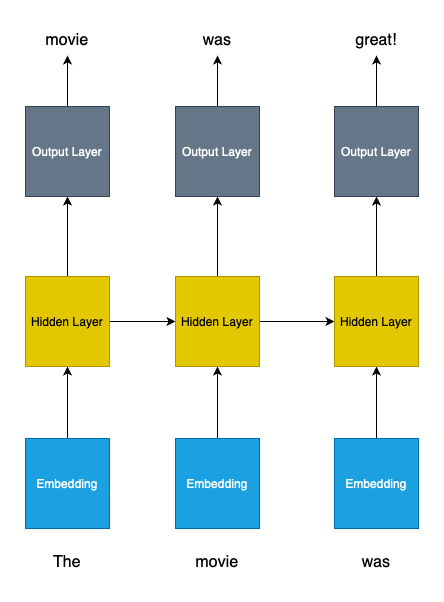

#### Importing Libraries

First we import the necessary libraries for data manipulation, model building, and training. No other libraries are allowed to be imported.

In [ ]:
import numpy as np
import gensim.downloader as api
from gensim.models import FastText, KeyedVectors
from tqdm import tqdm

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re

#### Load and Prepare Data

Next, we load the IMDb dataset and prepare it for training.

In [ ]:
vocab_size = 1000
maxlen = 100

In [ ]:
(x_train, _), (x_test, _) = imdb.load_data(num_words=vocab_size + 3, maxlen=maxlen)

In [ ]:
# Create a one-hot encoded representation of the training data
x_train_one_hot_encoded = np.zeros((x_train.shape[0], maxlen, vocab_size))

# Iterate over each sample and each word index to set the one-hot value to 1
for i in range(x_train.shape[0]):
    for j in range(len(x_train[i])):
        idx = x_train[i][j] - 3
        if idx < 0:
          idx = 0
        x_train_one_hot_encoded[i, j, idx] = 1

In [ ]:
# Decode the dataset back into words to train Word2Vec
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items() if v < vocab_size}

x_train_words = [[index_word.get(idx-3, "unk") for idx in sequence] for sequence in x_train]
x_test_words = [[index_word.get(idx-3, "unk") for idx in sequence] for sequence in x_test]

In [ ]:
embedding_model = api.load("glove-twitter-50")
embedding_size = embedding_model.vector_size

In [ ]:
def embed_sequences(sequences, embedding_model, maxlen, embedding_size):
    embeddings = []
    for sequence in sequences:
        seq_embedding = [
            embedding_model[word] if word in embedding_model else np.zeros(embedding_size)
            for word in sequence
        ]
        if len(seq_embedding) < maxlen:
            # Padding with zero vectors if sequence is shorter
            seq_embedding += [np.zeros(embedding_size)] * (maxlen - len(seq_embedding))
        if len(seq_embedding) > maxlen:
            seq_embedding = seq_embedding[:maxlen]

        embeddings.append(seq_embedding)
    return np.array(embeddings)

In [ ]:
x_train_embeddings = embed_sequences(x_train_words, embedding_model, maxlen, embedding_size)
y_train_outputs = x_train_one_hot_encoded

# Get correct values for next word prediction
x_train_embeddings = x_train_embeddings[:, :maxlen - 1, :]
y_train_outputs = y_train_outputs[:, -(maxlen - 1):, :]

#### Softmax Function (2 Points)

Implement the softmax function to be used in the output layer. The fucntion should take in a one dimensional numpy array and compute softmax.

In [ ]:
def softmax(x: np.ndarray) -> np.ndarray:

    ex = np.exp(x)
    return ex / np.sum(ex)

    pass

#### Input Layer Class (8 points)

Define the InputLayer class. The input player includes the following variables:   This variable represents the weight matrix connecting the input layer to the hidden layer. The dimensions are defined by the hidden size and the size of the input at each time step. It is initialized with small random values to facilitate learning during training.

Variables:
- `inputs`: The input sequences for the RNN, which are encoded using word2vec. It has a shape of (max_sequence_length, word2vec_size).
- `weights`: This weight matrix connecting the input layer to the hidden layer.
- `delta_weights`: The accumulation of the weight matrix gradients calculated across timesteps during backpropogation.

You must implement the following functions:
- `forward`: Multiply the input by the weight matrix. The output is a weighted sum that will be passed to the hidden layer for further processing. (4 points)

- `backward`: Calculate the gradient of the forward operation and add that value to `self.delta_weights`, to be updated in `update_parameters`. (4 points)



In [ ]:
class InputLayer:
    inputs: np.ndarray
    weights: np.ndarray = None
    delta_weights: np.ndarray = None

    def __init__(self, inputs: np.ndarray, hidden_size: int) -> None:
        self.inputs = inputs

        limit = np.sqrt(6 / (len(inputs[0]) + hidden_size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(hidden_size, len(inputs[0])))

        self.delta_weights = np.zeros_like(self.weights)

    def __reset_deltas__(self):
        self.delta_weights = np.zeros_like(self.weights)

    def get_input(self, time_step: int) -> np.ndarray:
        return self.inputs[time_step][:, np.newaxis]

    def forward(self, time_step: int) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        inp = self.get_input(time_step)
        weighted = np.dot(self.weights, inp)
        return weighted

    def backward(
        self, time_step: int, delta_weights: np.ndarray
    ) -> None:
        ### BEGIN IMPLEMENTATION ###
        inp = self.get_input(time_step)
        self.delta_weights += np.dot(delta_weights, inp.T)

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights

        self.__reset_deltas__()

#### Hidden Layer Class (8 points)

Define the HiddenLayer class. The hidden layer maintains the hidden states across time steps and computes the activations based on the weighted sum of the inputs, computed in the input layer, and the previous hidden state.

variables:
- `states`: The hidden states for all time steps during the sequence processing. It has a shape of (max_num_time_steps, hidden_size, 1).

- `weights`: The weight matrix connecting the previous hidden layer.

- `bias`: The bias vector added to the weighted sum of inputs and hidden states.

- `delta_weights`: The accumulation of gradients of the weight matrix computed during backpropogation.

- `delta_bias`: The accumulation of gradients of the bias vector computed during backpropogation.

- `next_delta_hidden_state_activation`: The gradient of the previously calculated hidden state activation.


You must implement the following functions:

- `forward`: This function computes the forward pass through the hidden layer. It combines the weighted input, the previous hidden state, and the bias, followed by applying the hyperbolic tangent activation function (tanh). The resulting activation is stored and returned for further processing. Be sure to update the hidden state using `set_hidden_state`. (4 points)

- `backward`: This function computes the gradients for backpropagation. It calculates the delta for the activation using the incoming delta_output, propagates the gradients back to the previous hidden state, and updates delta_weights and delta_bias based on the computed gradients. (4 points)

In [ ]:
class HiddenLayer:
    states: np.ndarray = None
    weights: np.ndarray = None
    delta_weights: np.ndarray = None
    bias: np.ndarray = None
    delta_bias: np.ndarray = None
    next_delta_hidden_state_activation: np.ndarray = None

    def __init__(self, max_num_time_steps: int, size: int) -> None:
        limit = np.sqrt(6 / (size + size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(size, size))

        self.bias = np.random.uniform(low=-0.1, high=0.1, size=(size, 1))
        self.states = np.zeros(shape=(max_num_time_steps, size, 1))
        self.next_delta_hidden_state_activation = np.zeros(shape=(size, 1))
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def __reset_deltas__(self):
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)
        self.next_delta_hidden_state_activation = np.zeros_like(self.next_delta_hidden_state_activation)

    def __reset_states__(self):
        self.states = np.zeros_like(self.states)

    def get_hidden_state(self, time_step: int) -> np.ndarray:
            if time_step < 0:
                return np.zeros_like(self.states[0])
            return self.states[time_step]

    def set_state(self, time_step: int, prediction: np.ndarray) -> None:
        self.states[time_step] = prediction

    def forward(self, weighted_input: np.ndarray, time_step: int) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        prev = self.get_hidden_state(time_step - 1)
        weighted = np.dot(self.weights, prev) + weighted_input + self.bias
        hidden = np.tanh(weighted)
        self.set_state(time_step, hidden)
        return hidden

    def backward(
        self, time_step: int, delta_output: np.ndarray
    ) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        curr = self.get_hidden_state(time_step)
        prev = self.get_hidden_state(time_step - 1)

        tanh = 1 - np.square(curr)
        delta_hidden = delta_output * tanh + self.next_delta_hidden_state_activation
        self.delta_weights += np.dot(delta_hidden, prev.T)
        self.delta_bias += delta_hidden

        self.next_delta_hidden_state_activation = np.dot(self.weights.T, delta_hidden)

        return self.next_delta_hidden_state_activation

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights
        self.bias -= learning_rate * self.delta_bias

        self.__reset_deltas__()


#### Output Layer Class (8 points)

Define the OutputLayer class. The output layer will generate a probability distribution from the hidden state.

Variables:
- `states`: The computed probability distributions across all timesteps.

- `weights`: The weight matrix connecting the hidden layer.

- `bias`: The bias vector added to the output of the weighted sum.

- `delta_weights`: The accumulation of gradients of the weight matrix computed during backpropogation.

- `delta_bias`: The accumulation of gradients of the bias vector computed during backpropogation.

You must implement the following functions:
- `forward`: This function computes the forward pass through the output layer. It multiplies the hidden state by the weight matrix, adds the bias, and applies the softmax function to produce a probability distribution over the vocabulary. The resulting predictions MUST be stored using `set_prediction`. (4 points)

- `backward`: This function computes the gradients for backpropagation based on the expected outputs, updates delta_V and delta_bias with the computed gradients, and returns the propagated error to the previous layer. (4 points)


In [ ]:
class OutputLayer:
    predictions: np.ndarray = None
    weights: np.ndarray = None
    bias: np.ndarray = None
    delta_bias: np.ndarray = None
    delta_weights: np.ndarray = None

    def __init__(self, max_num_time_steps: int, size: int, hidden_size: int) -> None:
        limit = np.sqrt(6 / (size + hidden_size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(size, hidden_size))
        self.bias = np.random.uniform(low=-0.1, high=0.1, size=(size, 1))
        self.predictions = np.zeros(shape=(max_num_time_steps, size, 1))
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def __reset_predictions__(self):
        self.predictions = np.zeros_like(self.predictions)

    def __reset_deltas__(self):
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def forward(self, hidden_state: np.ndarray, time_step: int) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        weighted_sum = np.dot(self.weights, hidden_state) + self.bias
        prediction = softmax(weighted_sum.flatten())[:, np.newaxis]
        self.set_prediction(time_step, prediction)
        return prediction

    def get_prediction(self, time_step: int) -> np.ndarray:
        return self.predictions[time_step]

    def set_prediction(self, time_step: int, prediction: np.ndarray) -> None:
        self.predictions[time_step] = prediction

    def backward(
        self,
        expected: np.ndarray,
        hidden_state: np.ndarray,
        time_step: int,
    ) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        prediction = self.get_prediction(time_step)

        if expected.ndim == 1:
          expected = expected.reshape(-1, 1)

        hidden_state = hidden_state.reshape(1, -1)
        delta = prediction - expected
        self.delta_bias = self.delta_bias + delta
        self.delta_weights += np.dot(delta, hidden_state)

        hidden = np.dot(self.weights.T, delta)

        return hidden

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights
        self.bias -= learning_rate * self.delta_bias

        self.__reset_deltas__()

#### RNN Class
The RNN class is a Recurrent Neural Network that combines the input, hidden, and output layers to process sequences of inputs, learn their representations, and generate predictions.

In [ ]:
from typing import List

class RNN:
    hidden_layer: HiddenLayer
    output_layer: OutputLayer
    learning_rate: float
    input_layer: InputLayer = None

    def __init__(self, vocab_size: int, hidden_size: int, max_num_time_steps: int, learning_rate: float) -> None:
        self.hidden_layer = HiddenLayer(max_num_time_steps, hidden_size)
        self.output_layer = OutputLayer(max_num_time_steps, vocab_size, hidden_size)
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

    def feed_forward(self, inputs: np.ndarray) -> OutputLayer:
        self.input_layer = InputLayer(inputs, self.hidden_size)

        for step in range(len(inputs)):
            weighted_input = self.input_layer.forward(step)
            activation = self.hidden_layer.forward(weighted_input, step)
            self.output_layer.forward(activation, step)

        return self.output_layer

    def backpropagation(self, expected: np.ndarray) -> None:
        for step_number in reversed(range(len(expected) - 1)):
            delta_output = self.output_layer.backward(
                expected[step_number],
                self.hidden_layer.get_hidden_state(step_number),
                step_number,
            )
            delta_weighted_sum = self.hidden_layer.backward(
                step_number, delta_output
            )
            self.input_layer.backward(step_number, delta_weighted_sum)


        self.output_layer.update_parameters(self.learning_rate)
        self.hidden_layer.update_parameters(self.learning_rate)
        self.input_layer.update_parameters(self.learning_rate)

    def loss(self, y_hat: List[np.ndarray], y: List[np.ndarray]) -> float:
        return -np.mean([np.sum(y[i] * np.log(y_hat[i])) for i in range(len(y))])

    def _find_end_of_seq(self, expected: np.ndarray) -> int:
        for idx, vector in enumerate(expected):
            if np.all(vector == 0):
                return idx
        return len(expected)

    def _reset_states(self):
      self.output_layer.__reset_predictions__()
      self.hidden_layer.__reset_states__()

    def train(self, inputs: np.ndarray, expected: np.ndarray, epochs: int) -> None:
        for epoch in range(epochs):
            loss_list = []
            for idx, input in enumerate(tqdm(inputs)):
                end_idx = self._find_end_of_seq(expected[idx])
                input = input[:end_idx, :]
                y_hats = self.feed_forward(input)
                self.backpropagation(expected[idx][:end_idx])

                round_loss = self.loss(y_hats.predictions[:end_idx,:,0], expected[idx][:end_idx])
                loss_list.append(round_loss)
                self._reset_states()

                if idx % 100 == 99:
                  print(f"Average Training Loss of Last 100 samples: {np.mean(np.array(loss_list[-100:]))}")

            print(
                f"Epoch Loss: {np.mean(np.array(loss_list))}"
            )


#### Running the RNN

Now we put it all together by initializing and training the RNN model. **Do not edit these hyperparameters**. Please do not change the hyperparameters. If done correctly, your loss should be below 5.0 after the second epoch.

In [ ]:
rnn = RNN(vocab_size=vocab_size, hidden_size=32, max_num_time_steps=maxlen - 1, learning_rate=1e-3)
rnn.train(x_train_embeddings, y_train_outputs, epochs=2)

  4%|▎         | 103/2773 [00:03<01:55, 23.06it/s]

Average Training Loss of Last 100 samples: 5.729925015268897


  7%|▋         | 206/2773 [00:07<00:55, 46.59it/s]

Average Training Loss of Last 100 samples: 5.085696734446683


 11%|█         | 307/2773 [00:08<00:45, 54.74it/s]

Average Training Loss of Last 100 samples: 4.999929981281585


 15%|█▍        | 409/2773 [00:10<00:45, 51.52it/s]

Average Training Loss of Last 100 samples: 5.001932212570699


 18%|█▊        | 507/2773 [00:12<00:44, 50.84it/s]

Average Training Loss of Last 100 samples: 4.914121215839478


 22%|██▏       | 607/2773 [00:15<00:44, 48.28it/s]

Average Training Loss of Last 100 samples: 4.853357402684159


 25%|██▌       | 704/2773 [00:17<01:31, 22.57it/s]

Average Training Loss of Last 100 samples: 4.907759586007796


 29%|██▉       | 804/2773 [00:21<00:43, 45.08it/s]

Average Training Loss of Last 100 samples: 4.908697163246297


 33%|███▎      | 906/2773 [00:23<00:37, 49.75it/s]

Average Training Loss of Last 100 samples: 4.902632328482609


 36%|███▋      | 1006/2773 [00:25<00:41, 42.87it/s]

Average Training Loss of Last 100 samples: 4.9556057856472115


 40%|███▉      | 1105/2773 [00:27<00:36, 45.80it/s]

Average Training Loss of Last 100 samples: 4.938296943633389


 43%|████▎     | 1206/2773 [00:29<00:30, 52.11it/s]

Average Training Loss of Last 100 samples: 4.909877154125709


 47%|████▋     | 1303/2773 [00:32<00:57, 25.43it/s]

Average Training Loss of Last 100 samples: 4.885121755725724


 51%|█████     | 1404/2773 [00:36<00:31, 43.40it/s]

Average Training Loss of Last 100 samples: 4.900442735079658


 54%|█████▍    | 1507/2773 [00:38<00:26, 47.47it/s]

Average Training Loss of Last 100 samples: 4.8537425272276975


 58%|█████▊    | 1605/2773 [00:40<00:23, 49.29it/s]

Average Training Loss of Last 100 samples: 4.867507830559273


 61%|██████▏   | 1703/2773 [00:42<00:21, 50.13it/s]

Average Training Loss of Last 100 samples: 4.937403028470473


 65%|██████▌   | 1806/2773 [00:44<00:20, 47.81it/s]

Average Training Loss of Last 100 samples: 4.94704680892209


 69%|██████▊   | 1902/2773 [00:47<00:34, 25.59it/s]

Average Training Loss of Last 100 samples: 4.858651893824225


 72%|███████▏  | 2007/2773 [00:51<00:17, 43.45it/s]

Average Training Loss of Last 100 samples: 4.91699418597502


 76%|███████▌  | 2106/2773 [00:53<00:13, 49.37it/s]

Average Training Loss of Last 100 samples: 4.861224736942688


 80%|███████▉  | 2206/2773 [00:55<00:13, 43.08it/s]

Average Training Loss of Last 100 samples: 4.829568006839445


 83%|████████▎ | 2308/2773 [00:57<00:10, 44.11it/s]

Average Training Loss of Last 100 samples: 4.937475915754938


 87%|████████▋ | 2407/2773 [00:59<00:07, 47.97it/s]

Average Training Loss of Last 100 samples: 4.858314796946937


 90%|█████████ | 2500/2773 [01:02<00:11, 23.38it/s]

Average Training Loss of Last 100 samples: 4.861502741411601


 94%|█████████▍| 2606/2773 [01:06<00:03, 48.11it/s]

Average Training Loss of Last 100 samples: 4.952594716079437


 98%|█████████▊| 2705/2773 [01:08<00:01, 47.71it/s]

Average Training Loss of Last 100 samples: 4.956730660413424


100%|██████████| 2773/2773 [01:10<00:00, 39.51it/s]


Epoch Loss: 4.944650359879543


  4%|▍         | 106/2773 [00:02<00:54, 49.21it/s]

Average Training Loss of Last 100 samples: 4.933781620062765


  8%|▊         | 210/2773 [00:04<00:48, 52.74it/s]

Average Training Loss of Last 100 samples: 4.862353553050716


 11%|█         | 305/2773 [00:07<01:28, 27.99it/s]

Average Training Loss of Last 100 samples: 4.8728237576802425


 15%|█▍        | 407/2773 [00:11<00:49, 47.74it/s]

Average Training Loss of Last 100 samples: 4.917136844835032


 18%|█▊        | 508/2773 [00:13<00:48, 46.51it/s]

Average Training Loss of Last 100 samples: 4.840998065841137


 22%|██▏       | 609/2773 [00:15<00:43, 49.64it/s]

Average Training Loss of Last 100 samples: 4.808181156747936


 25%|██▌       | 705/2773 [00:17<00:40, 50.65it/s]

Average Training Loss of Last 100 samples: 4.869356288333282


 29%|██▉       | 805/2773 [00:19<00:36, 54.18it/s]

Average Training Loss of Last 100 samples: 4.87178770512265


 32%|███▏      | 901/2773 [00:21<01:23, 22.34it/s]

Average Training Loss of Last 100 samples: 4.873306424495522


 36%|███▌      | 1003/2773 [00:25<00:42, 41.93it/s]

Average Training Loss of Last 100 samples: 4.929510095959018


 40%|███▉      | 1106/2773 [00:28<00:32, 51.39it/s]

Average Training Loss of Last 100 samples: 4.918420730896767


 44%|████▎     | 1208/2773 [00:30<00:28, 54.81it/s]

Average Training Loss of Last 100 samples: 4.893807639125864


 47%|████▋     | 1307/2773 [00:32<00:27, 53.12it/s]

Average Training Loss of Last 100 samples: 4.8682890854641485


 51%|█████     | 1407/2773 [00:34<00:32, 42.65it/s]

Average Training Loss of Last 100 samples: 4.888765454192461


 54%|█████▍    | 1501/2773 [00:38<01:01, 20.67it/s]

Average Training Loss of Last 100 samples: 4.841980409391379


 58%|█████▊    | 1609/2773 [00:41<00:24, 47.70it/s]

Average Training Loss of Last 100 samples: 4.857464808708293


 61%|██████▏   | 1702/2773 [00:43<00:21, 49.81it/s]

Average Training Loss of Last 100 samples: 4.9289944369565


 65%|██████▌   | 1809/2773 [00:45<00:19, 49.60it/s]

Average Training Loss of Last 100 samples: 4.936611717193291


 69%|██████▉   | 1908/2773 [00:47<00:18, 46.47it/s]

Average Training Loss of Last 100 samples: 4.853227468238106


 72%|███████▏  | 2004/2773 [00:49<00:15, 49.75it/s]

Average Training Loss of Last 100 samples: 4.909310781717925


 76%|███████▌  | 2105/2773 [00:53<00:28, 23.04it/s]

Average Training Loss of Last 100 samples: 4.855286166359476


 80%|███████▉  | 2206/2773 [00:56<00:12, 44.51it/s]

Average Training Loss of Last 100 samples: 4.825046989971408


 83%|████████▎ | 2304/2773 [00:58<00:10, 45.92it/s]

Average Training Loss of Last 100 samples: 4.933355133185259


 87%|████████▋ | 2408/2773 [01:00<00:07, 47.48it/s]

Average Training Loss of Last 100 samples: 4.853908238402883


 90%|█████████ | 2505/2773 [01:02<00:05, 46.13it/s]

Average Training Loss of Last 100 samples: 4.858041769447614


 94%|█████████▍| 2610/2773 [01:04<00:03, 51.25it/s]

Average Training Loss of Last 100 samples: 4.949294352457911


 97%|█████████▋| 2701/2773 [01:08<00:03, 20.11it/s]

Average Training Loss of Last 100 samples: 4.953811233990157


100%|██████████| 2773/2773 [01:10<00:00, 39.11it/s]

Epoch Loss: 4.885874019958818


# Question 2 (30 points in total)
- In this question, you will count the number of parameters in GPT-2 and trace the source code of different LLM implementations to better understand the Transformer architecture.

## Q2.1 Understand Transformer with parameter counting exercise (19 points in total)

### Let’s count the number of parameters in GPT-2-XL.
- You are only allowed to use the variable names defined below to answer the questions, i.e., `n_layers * n_heads` is allowed, while `4 * d_ffn` is not allowed.
- For simplicity, please **ignore the bias terms** in all questions.

In [ ]:
n_layers = 48  # the number of transformer layers (aka. transformer blocks)
n_heads = 25   # the number of attention heads in each layer
d_model = 1600 # the model dimension
d_ffn = 6400   # the FFN (aka. MLP) dimension
d_heads = 64   # the attn head dimension
n_vocab = 50257 # vocabulary size
n_ctx = 1024    # the maximum sequence length the model can process

#### Q2.1.1 The input embeddings consists of token embeddings (2 points) and position embeddings (2 points). Count the number of parameters in the two embeddings.

In [ ]:
token_embeddings = n_vocab * d_model
print(token_embeddings)

80411200


In [ ]:
position_embeddings =  n_ctx * d_model
print(position_embeddings)

1638400


#### Q2.1.2 Multi-Headed Attention consists of W_Q (1.5 point), W_K (1.5 point), W_V (1.5 points), and W_O (3.5 points),
- MultiHead(Q, K, V) = Concat(head_1, ..., head_n) W_O
- see more details in https://arxiv.org/pdf/1706.03762
#### Count the number of parameters in them.
- Here we * n_layers to calculate the total number of parameters across layers.

In [ ]:
attn_q = n_layers * d_model**2
print(attn_q)

122880000


In [ ]:
attn_k = n_layers * d_model**2
print(attn_k)

122880000


In [ ]:
attn_v = n_layers * d_model**2
print(attn_v)

122880000


In [ ]:
attn_o = n_layers * d_model**2
print(attn_o)

122880000


#### Q2.1.3 The feed-forward network (FFN) in each transformer block consists of two layers, ffn1 (1.5 point) and ffn2 (1.5 point). Count the number of parameters in them, respectively.
- You need to * n_layers to calculate the total number of parameters across layers.

In [ ]:
ffn1 = n_layers * d_model * d_ffn
print(ffn1)

491520000


In [ ]:
ffn2 = n_layers * d_ffn * d_model
print(ffn2)

491520000


#### Q2.1.4 Count the number of parameters in the output embeddings (2 points)

In [ ]:
output_embeddings = n_vocab * d_model
print(output_embeddings)

80411200


#### Q2.1.5 Print out the total number of parameters (1 point).
- We do not double-count output_embeddings because GPT-2 shares the weights of token_embeddings and output_embeddings.
- For simplicity, we ignore the bias terms and layernorms.

In [ ]:
n_total = token_embeddings + position_embeddings + attn_q + attn_k + attn_v + attn_o + ffn1 + ffn2
print(f'{n_total/10**9:.3f}B')

1.557B


#### Q2.1.6 The majority of parameters are in the FFN layers! Print the percentage (1 point).

In [ ]:
print(f'{(ffn1+ffn2)/n_total:.1%}')

63.2%


## Q2.2 Understand different implementations of large language models (11 points in total)

### Different LLMs use slightly different architectures. Please read the snippets of three types of implentations below and answer the questions.
- The code is modified from Hugging Face's implementations. To answer the questions, you do not need to understand the classes and variables that are not defined in the snippets.
- `d_model`: the model dimension
- `d_ffn`: the FFN (aka. MLP) dimension

In [ ]:
%%script echo skipping
class GPT2MLP(nn.Module):
    def __init__(self, config, d_model, d_ffn):
        super().__init__()
        self.fn1 = nn.Linear(d_model, d_ffn)
        self.fn2 = nn.Linear(d_ffn, d_model)
        self.act = ACT2FN[config.activation_function]
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, hidden_states: Optional[Tuple[torch.FloatTensor]]) -> torch.FloatTensor:
        hidden_states = self.fn1(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.fn2(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states


class GPT2Block(nn.Module):
    def __init__(self, config, d_model, d_ffn, layer_idx=None):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model, eps=config.layer_norm_epsilon)
        self.attn = GPT2_ATTENTION_CLASSES[config._attn_implementation](config=config, layer_idx=layer_idx)
        self.ln_2 = nn.LayerNorm(d_model, eps=config.layer_norm_epsilon)
        self.mlp = GPT2MLP(config, d_model, d_ffn)

    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        attention_mask: Optional[torch.FloatTensor] = None,
    ):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_output = self.attn(
            hidden_states,
            attention_mask=attention_mask,
        )
        # residual connection
        hidden_states = attn_output + residual
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        return hidden_states

skipping


In [ ]:
%%script echo skipping
class GPTJBlock(nn.Module):
    def __init__(self, config, d_model, d_ffn, layer_idx=None):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model, eps=config.layer_norm_epsilon)
        self.attn = GPTJ_ATTENTION_CLASSES[config._attn_implementation](config, layer_idx)
        self.mlp = GPTJMLP(config, d_model, d_ffn)

    def forward(
        self,
        hidden_states: Optional[torch.FloatTensor],
        attention_mask: Optional[torch.FloatTensor] = None,
    ):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_output = self.attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
        )

        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = attn_output + feed_forward_hidden_states + residual

        return hidden_states

skipping


In [ ]:
%%script echo skipping
class LlamaMLP(nn.Module):
    def __init__(self, config, d_model, d_ffn):
        super().__init__()
        self.gate_proj = nn.Linear(d_model, d_ffn, bias=config.mlp_bias)
        self.up_proj = nn.Linear(d_model, d_ffn, bias=config.mlp_bias)
        self.down_proj = nn.Linear(d_ffn, d_model, bias=config.mlp_bias)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        # x: [BS, d_model]
        hidden_states = self.act_fn(self.gate_proj(x)) * self.up_proj(x)
        output = self.down_proj(hidden_states)
        return output

skipping


#### Q2.2.1 What are the differences between `GPTJBlock()` and `GPT2Block()`? (7 points)
- Hint: (1) When do self.attn() and self.mlp() add to the residual stream, respectively? (2) What's the input of self.mlp()?
- **Ignore** the differences in bias terms, layernorm, dropout, and activation functions.


1.   

*  In GPT2Block(), self.attn() adds to the residual stream after using it to get the attention output, this addidition updates the hidden state. After doing the second layer normalization to adjust hidden_states, self.mlp() is applied to hidden_states and added to the residual stream
*   This is different to GPTJBlock(), where self.attn() and self.mlp() are added together to the residual stream



2.   


*   In GPT2Block(), self.mlp() takes as its input the second layer normalization of the hidden_states, which comes after the attention mechanism
*   In GPTJBlock(), self.mlp() takes the first layer normalization, meaning there is no normalization of the attention mechanism thats passed in





#### Q2.2.2 In `LlamaMLP()`, the shape of the input `x` is `[BS, d_model]`. What are the shapes of `self.act_fn(self.gate_proj(x))`, `self.up_proj(x)`, `hidden_states`, and `output`, respectively? Answer with the variable names (4 points).
- The type of the activation function (ReLU, SiLU, or Sigmoid) does not change the answer

#### Your answer here
- (1 point) The shape of the output of `self.act_fn(self.gate_proj(x))`: [BS, d_ffn]
- (1 point) The shape of the output of `self.up_proj(x)`: [BS, d_ffn]
- (1 point) The shape of `hidden_states`: [BS, d_ffn]
- (1 point) The shape of `output`: [BS, d_model]

# Question 3: Finetuning

In this question, you will be asked to finetune a pretrained language model DistillBERT on sentiment analysis task using IMDb dataset.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00


In [2]:
#load dataset
# we use imdb dataset to finetune the model. We test the model on imdb and sst2.
from datasets import load_dataset

imdb_dataset = load_dataset('stanfordnlp/imdb')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## 1. Preprocess the data (4pts)


For imdb, split the train dataset into train set and dev set. The dev set is used within training process to select the best checkpoint. Use train_test_split() from sklearn to split. The ratio of dev set is 0.1. Set the random state as 42.

In [3]:
from sklearn.model_selection import train_test_split
# write your code here, make sure you use the name defined below.

train_data = imdb_dataset['train']

splitter = train_test_split(train_data['text'], train_data['label'], test_size=0.1, random_state=42, stratify=train_data['label'])

train_x, dev_x, train_y, dev_y = splitter



In [4]:
print(train_x[0])

"Algie, the Miner" is one bad and unfunny silent comedy. The timing of the slapstick is completely off. This is the kind of humor with certain sequences that make you wonder if they're supposed to be funny or not. However, the actual quality of the film is irrelevant. This is mandatory viewing for film buffs mainly because its one of the earliest examples of gay cinema. The main character of Algie is an effeminate guy, acting much like the stereotypical "pansy" common in many early films. The film has the homophobic attitude common of the time. "Algie, the Miner" is pretty awful, but fascinating from a historical viewpoint. (3/10)


## 2. Prepare the data (10pts)


We use Dataset class from torch.utils.data to prepare data, and DataLoader class to prepare batches for training.

In the SentimentAnalysisDataset class, you need to use DistillBert tokenizer to tokenize the sentence.

In [5]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
from torch.utils.data import Dataset, DataLoader

import torch


class SentimentAnalysisDataset(Dataset):
  #write your code here
  def __init__(self,data, tokenizer, max_len = 512):
    self.input_texts = data['input']
    self.labels = data['label']
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.prepare()


  def prepare(self):
    encodings = self.tokenizer(self.input_texts, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
    self.input_ids = encodings['input_ids']
    self.len = len(self.input_texts)
    self.attention_masks = encodings['attention_mask']


  def __len__(self):
    return self.len

  def __getitem__(self,idx):
    return {
            'input_ids': self.input_ids[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
             'attention_mask': self.attention_masks[idx]
          }

# Example of usage
# Usage of GPU: due to limit usage of GPU on Colab, we will not train the whole training set. If you can get access to GPU, we strongly recommend you to run it on GPU and try it on the whole dataset. In this homework, we only run first 20 samples.
train = {'input':train_x[:20], 'label':train_y[:20]}
train_dataset = SentimentAnalysisDataset(train, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)


In [7]:
assert sum(train_dataset.attention_masks[0])==149

## 3. Define the model (12pts)

We use DistillBERT as base model. We still need a linear layer to mapping the last hidden state to classes dimension.

The model should have a base model, a linear layer, a dropout layer (0.5) and softmax function. The forward function go through all the layers one by one and return the softmax result.

In [8]:
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bertmodel = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

class ClassificationModel(nn.Module):
    def __init__(self,base_model,num_classes):
        super().__init__()
        torch.manual_seed(42)
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(base_model.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self,input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last = outputs.last_hidden_state

        out = last[:, 0, :]
        out = self.dropout(out)
        logits = self.classifier(out)
        predicts = self.softmax(logits)

        return predicts

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [9]:
model = ClassificationModel(base_model = bertmodel, num_classes = 2 )

In [10]:
#test case
input_ids = train_dataset.input_ids[0]
attention_mask = train_dataset.attention_masks[0]
model.eval()
with torch.no_grad():
  predicts = model(input_ids,attention_mask)


In [11]:
assert predicts.tolist() == [[0.4507104158401489, 0.5492895841598511]]

## 4. Model finetuning (10pts)

In this section, you need to implement train loop and evaluation loop.

 Initialize the optimizer. We use AdamW for optimizer and cross entropy loss. (3pts)

In [12]:
from transformers import AdamW
from torch import nn

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


We use pytorch to implement. For each epoch, we run one training loop and one evaluation loop. At the end of training, we run the model on test set using the best model saved. For one training step, we run forward pass using pretrained model given input. Then we calculate loss and do backward propagation. See the instructions in the code block.  (7pts)

Ideally, you should see a obvious decrease (0.7-1) in train loss, but no decrease in dev loss, since the model is overfitting on a small training set.


In [13]:
from tqdm import tqdm
epochs = 10 # don't change

dev = {'input': dev_x[:20], 'label': dev_y[:20]}
dev_dataset = SentimentAnalysisDataset(dev, tokenizer)
dev_dataloader = DataLoader(dev_dataset, batch_size=4, shuffle=False)

num_training_steps = epochs * len(train_dataloader)
best_model = None

best_loss = 10000

with tqdm(total=num_training_steps, desc='Finetuning:') as pbar:
  for epoch in range(epochs):
    # training loop
    model.train()
    train_loss = 0
    for batch in train_dataloader:
      '''
      #Tips:
      #1. Put the input and model on the same device
      #2. Use the optimizer correctly
      #3. Update the train loss. The printed train loss should be train_loss/len(train_dataloader)
      '''
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

      pbar.update(1)

    train_loss /= len(train_dataloader)

    print(f'Epoch {epoch}: train loss is {train_loss}')
    model.eval()
    with torch.no_grad():
      for batch in dev_dataloader:

        dev_loss = 0
        '''
        #Tips:
        #1. You don't need to use optimizer
        #2. Update the dev loss. The printed dev loss should be dev_loss/len(dev_dataloader)
        #3. Save the checkpoint if the dev loss is smaller than best loss and update the best loss to dev loss
        '''
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch['labels'].to(device)

        dev_loss += (loss_fn(outputs, labels)).item()

      dev_loss /= len(dev_dataloader)

      print(f'Epoch {epoch}: dev loss is {dev_loss}')
      if dev_loss < best_loss:
        #save the checkpoint
        # write your code here
        best_loss = dev_loss
        best_model = model.state_dict()
        print(f'The best loss is {dev_loss}. Saving checkpoint!')



Finetuning::  10%|█         | 5/50 [01:03<09:15, 12.34s/it]

Epoch 0: train loss is 0.7168913602828979
Epoch 0: dev loss is 0.13982388973236085
The best loss is 0.13982388973236085. Saving checkpoint!


Finetuning::  20%|██        | 10/50 [02:20<08:51, 13.29s/it]

Epoch 1: train loss is 0.6407652020454406
Epoch 1: dev loss is 0.14688487052917482


Finetuning::  30%|███       | 15/50 [03:38<07:48, 13.38s/it]

Epoch 2: train loss is 0.601244056224823
Epoch 2: dev loss is 0.14456632137298583


Finetuning::  40%|████      | 20/50 [04:55<06:44, 13.50s/it]

Epoch 3: train loss is 0.5604805827140809
Epoch 3: dev loss is 0.13324917554855348
The best loss is 0.13324917554855348. Saving checkpoint!


Finetuning::  50%|█████     | 25/50 [06:16<05:56, 14.27s/it]

Epoch 4: train loss is 0.4591250240802765
Epoch 4: dev loss is 0.12671756744384766
The best loss is 0.12671756744384766. Saving checkpoint!


Finetuning::  60%|██████    | 30/50 [07:34<04:35, 13.76s/it]

Epoch 5: train loss is 0.38872148394584655
Epoch 5: dev loss is 0.1142874002456665
The best loss is 0.1142874002456665. Saving checkpoint!


Finetuning::  70%|███████   | 35/50 [08:52<03:23, 13.59s/it]

Epoch 6: train loss is 0.3359201192855835
Epoch 6: dev loss is 0.10968742370605469
The best loss is 0.10968742370605469. Saving checkpoint!


Finetuning::  80%|████████  | 40/50 [10:09<02:15, 13.55s/it]

Epoch 7: train loss is 0.32198120951652526
Epoch 7: dev loss is 0.11147468090057373


Finetuning::  90%|█████████ | 45/50 [11:28<01:08, 13.69s/it]

Epoch 8: train loss is 0.3174197733402252
Epoch 8: dev loss is 0.11305688619613648


Finetuning:: 100%|██████████| 50/50 [12:47<00:00, 13.93s/it]

Epoch 9: train loss is 0.31589815616607664


Finetuning:: 100%|██████████| 50/50 [13:04<00:00, 15.69s/it]

Epoch 9: dev loss is 0.11336687803268433
